# Character-Level MLP Model

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/tensorflow/05-tensorflow-cnn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)

---

## Introduction

In this notebook we implement a **multilayer perceptron** (MLP) character-level language model. We will improve our previous bigram character-level language model on maximizing the likelihood of a next character by passing embeddings of characters in its context to an MLP network. Instead of learning a large lookup table for each character combination as in the previous notebook, here the embedding vectors are combined to make a prediction, allowing for better generalization with less parameters to learn.

This notebook is based on [this tutorial](https://www.youtube.com/watch?v=TCH_1BHY58I) by [Andrej Karpathy](https://karpathy.ai/) on language modeling. 

In [1]:
import torch

import math
import warnings
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib_inline import backend_inline

DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 42
TRAIN_RATIO = 1.0

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')

Same **names dataset** as previous notebook:

In [2]:
names = open(DATASET_DIR / 'names.txt', 'r').read().splitlines()
names = names[:int(TRAIN_RATIO * len(names))]

print(len(names))
names[:10]

32033


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

We will use the same dataset builder from the previous notebook.

In [3]:
class CharDataset:
    def __init__(self, names, block_size):
        self.names = names
        self.chars = ['.'] + sorted(list(set(''.join(names))))
        self.block_size = block_size
        self.itos = dict(enumerate(self.chars))
        self.stoi = {c: i for i, c in self.itos.items()}

    def decode(self, x):
        return ''.join(self.itos[i] for i in x)

    def encode(self, word):
        return [self.stoi[c] for c in word]

    def build_dataset(self):
        """Creating subsequences -> next character target."""
        xs = []
        ys = []
        for name in self.names:
            context = ['.'] * self.block_size
            for c in name + '.':
                xs.append(self.encode(''.join(context)))
                ys.append(self.stoi[c])
                context = context[1:] + [c]
        
        return torch.tensor(xs), torch.tensor(ys)

Note that we simply encode each character in a block to its corresponding integer.

In [4]:
import pandas as pd

dataset = CharDataset(names, block_size=3)
itos = dataset.itos
stoi = dataset.stoi

xs, ys = dataset.build_dataset()

df = pd.DataFrame({'xs': list(xs.numpy()), 'ys': list(ys.numpy())})
df['seq'] = df['xs'].apply(lambda x: ''.join(itos[c] for c in x))
df['target'] = df['ys'].map(itos)
df.head(12)

,xs,ys,seq,target
0,"[0, 0, 0]",5,...,e
1,"[0, 0, 5]",13,..e,m
2,"[0, 5, 13]",13,.em,m
3,"[5, 13, 13]",1,emm,a
4,"[13, 13, 1]",0,mma,.
5,"[0, 0, 0]",15,...,o
6,"[0, 0, 15]",12,..o,l
7,"[0, 15, 12]",9,.ol,i
8,"[15, 12, 9]",22,oli,v
9,"[12, 9, 22]",9,liv,i


**Block size.** In the experiments below, we will be using block size of 3. Meaning, we will use the previous 3 characters to predict the next one. This makes sense since most names have around 6 to 7 characters. 

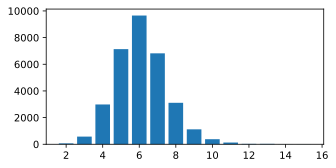

In [5]:
from collections import Counter

count = Counter([len(n) for n in names])
plt.figure(figsize=(5, 2.5))
plt.bar(count.keys(), count.values());

## Character embeddings

Recall that the names we generated using bigrams were pretty bad. Trigrams improve this a bit. But it required a significantly larger matrix. Indeed, if we use $k$ characters as context, the requires $27^k$ rows to record all counts. There is not enough data to train this model. 

Instead, we learn **embeddings** for the characters, i.e. learnable vector representations of characters, along with the parameters of the MLP network for combining the embedding vectors to calculate probabilities. This model architecture is based on  {cite}`bengio2003a`.

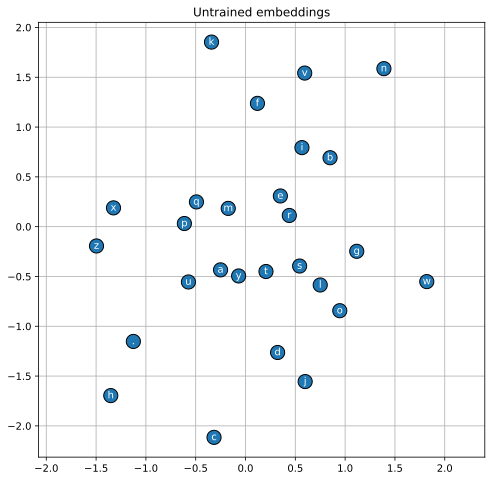

In [6]:
import torch
import string

g = torch.Generator().manual_seed(0)
C = torch.randn(27, 2, generator=g)
chars = '.' + string.ascii_lowercase

plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200, zorder=3, edgecolors='black')
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), chars[i], ha="center", va="center", color='white')

plt.grid('minor')
plt.axis('equal')
plt.title("Untrained embeddings");

Initially, the vector representation of the characters are randomly distributed in the *m*-dimensional space. This embedding will be tuned by the network so that similar characters moves closer to each other in the embedding space. 

Unlike in our previous model for *n*-grams which essentially learns a lookup table, this can easily represent character sequences that are out-of-distribution, i.e. those that appear very rarely in the training data. The embedding allows transfer of knowledge for different contexts by means of character similarity. This allows the model to generalize better. 

## Network architecture

We will implement the neural network shown in the following figure. First, we have the lookup table for embedding the characters. The results of the embedding are concatenated in the correct order and passed to the 2-layer MLP. Note that the weights of the MLP adjusts for ordering. The first layer applies the tanh nonlinearity. The second layer simply performs a linear operation to get the logits. 

We maximize the predict probability of the next character given the parameters of the network, which includes the parameters of the layers and the embedding table. To get the unnormalized distribution, we simply apply `.exp()` on the logits. Note that the input and output layer of the network has the same width.

```{figure} ../../img/mlp-char-level.drawio.svg
---
width: 600px
name: bigram-nn.drawio
---

Schematic diagram of our MLP neural net with embedding and block size of 3. Shown here is the input string `"ner"` passed to the embedding layer. The resulting concatenation of embeddings are passed to the two-layer MLP with logits. Note that the embeddings are concatenated in the correct order.
```

In [7]:
class MLP:
    def __init__(self, embedding_size, width, block_size, seed=2147483647):
        self.width = width
        self.blk_size = block_size
        self.emb_size = embedding_size
        self._init_weights(seed)
        
    def _init_weights(self, seed):
        self.g = torch.Generator().manual_seed(seed)
        self.C  = torch.randn(27, self.emb_size,                            generator=self.g)
        self.W1 = torch.randn((self.blk_size * self.emb_size, self.width),  generator=self.g)
        self.b1 = torch.randn(self.width,                                   generator=self.g)
        self.W2 = torch.randn((self.width, 27),                             generator=self.g)
        self.b2 = torch.randn(27,                                           generator=self.g)
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad = True

    def __call__(self, xs: list[int]):
        x = self.C[xs].view(-1, self.blk_size * self.emb_size)
        h = torch.tanh(x @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        return logits

    def zero_grad(self):
        for p in self.parameters:
           p.grad = None

    def optim_step(self, lr):
        for p in self.parameters:
           p.data -= lr * p.grad

**Remark.** Using `.view` so that the same underlying storage of the tensor is used in the computation.

### Model training

Optimizing `F.cross_entropy` loss which expects logits (unnormalized scores). This is equivalent to maximizing next character likelihood.

In [8]:
import torch.nn.functional as F

def train_model(model, xs, ys, num_steps=100, lr=0.1):
    
    losses = []
    for k in range(num_steps):
        logits = model(xs)
        loss = F.cross_entropy(logits, target=ys)

        model.zero_grad()
        loss.backward()
        model.optim_step(lr=lr)

        # logging
        losses.append(loss.item())
        if k > 0 and ((k % (num_steps // 10) == 0) or (k == num_steps - 1)):
            print(f"[{k+1:>03d}/{num_steps}]   loss={loss:.4f}")
    
    return losses


model = MLP(embedding_size=2, width=100, block_size=3)
hist = train_model(model, xs, ys, num_steps=100, lr=0.1)

[011/100]   loss=10.7096
[021/100]   loss=8.3292
[031/100]   loss=6.7950
[041/100]   loss=5.8032
[051/100]   loss=5.1055
[061/100]   loss=4.5874
[071/100]   loss=4.2026
[081/100]   loss=3.9281
[091/100]   loss=3.7287
[100/100]   loss=3.5893


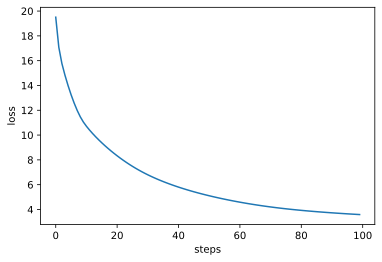

In [9]:
plt.plot(hist)
plt.ylabel('loss')
plt.xlabel('steps');

### Using mini-batches

It is crucial to use **mini-batches** to approximate the gradient. This leads to noisier and more updates, but drastically reduces the resources needed for training. Updating training function:

In [10]:
def train_step(model, xs_trn, ys_trn, generator, batch_size=32, lr=0.1):
    """One step of backprop and weight update."""
    
    B = torch.randint(
        0, xs_trn.shape[0], 
        (batch_size,), 
        generator=generator
    )
    
    logits = model(xs_trn[B])
    loss = F.cross_entropy(logits, target=ys_trn[B])

    model.zero_grad()
    loss.backward()
    model.optim_step(lr=lr)

    return loss.item()


def train_model(
        model, 
        xs_trn, ys_trn, 
        batch_size, 
        num_steps, 
        lr=0.1, 
        verbose=True, seed=42
    ):

    losses = []
    g = torch.Generator().manual_seed(seed)
    for k in range(num_steps):
        
        loss = train_step(model, xs_trn, ys_trn, g, batch_size, lr)

        # logging
        losses.append(loss)
        if verbose and ((k % (num_steps // batch_size) == 0) or (k == num_steps - 1)):
            print(f"[{k+1:>0{int(len(str(num_steps)))}d}/{num_steps}]   loss: {loss:.4f}")

    return losses


model = MLP(embedding_size=2, width=100, block_size=3)
hist = train_model(model, xs, ys, batch_size=32, num_steps=10000, lr=0.1)

[00001/10000]   loss: 17.3533
[00313/10000]   loss: 3.1909
[00625/10000]   loss: 2.3746
[00937/10000]   loss: 2.9336
[01249/10000]   loss: 2.7388
[01561/10000]   loss: 2.6701
[01873/10000]   loss: 2.6746
[02185/10000]   loss: 2.3285
[02497/10000]   loss: 2.8161
[02809/10000]   loss: 2.6688
[03121/10000]   loss: 2.4861
[03433/10000]   loss: 2.3500
[03745/10000]   loss: 2.3921
[04057/10000]   loss: 2.4572
[04369/10000]   loss: 2.6916
[04681/10000]   loss: 2.4224
[04993/10000]   loss: 2.1262
[05305/10000]   loss: 2.4351
[05617/10000]   loss: 2.5598
[05929/10000]   loss: 2.3319
[06241/10000]   loss: 2.6329
[06553/10000]   loss: 2.5195
[06865/10000]   loss: 2.7876
[07177/10000]   loss: 2.5837
[07489/10000]   loss: 2.6217
[07801/10000]   loss: 2.2596
[08113/10000]   loss: 2.4977
[08425/10000]   loss: 2.4559
[08737/10000]   loss: 2.6493
[09049/10000]   loss: 2.5435
[09361/10000]   loss: 2.5106
[09673/10000]   loss: 2.3888
[09985/10000]   loss: 2.6498
[10000/10000]   loss: 2.2048


Noisier updates:

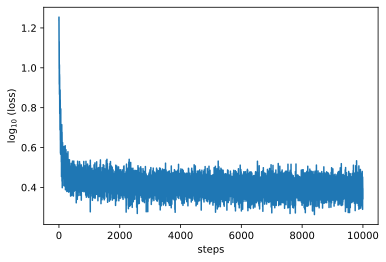

In [11]:
plt.plot(torch.tensor(hist).log10(), )
plt.xlabel("steps")
plt.ylabel("$\log_{10}$ (loss)");

## Tuning the hyperparameters

### Finding a good base learning rate

To find a good base learning rate, we gradually increasing the learning rate linearly in its exponent, at each step in gradient descent up to the point that it destablizes. Then, we work backwards by decreasing the learning rate via a **schedule**. This is an empirical heuristic that works well in practice, and is really cheap to compute (e.g. compared to a nested loop which does not make sense given that we have a schedule anyway). 

In [12]:
def find_base_lr(model, xs_trn, ys_trn, num_steps, batch_size=32, lre_min=-3, lre_max=0, seed=42, plot=True, color='C0'):
    """Finding a good base learning rate for training."""

    # Training loss at each step
    lre = torch.linspace(lre_min, lre_max, num_steps)
    lrs = 10 ** lre
    
    losses = []
    g = torch.Generator().manual_seed(seed)
    for k in range(num_steps):
        loss = train_step(model, xs_trn, ys_trn, g, batch_size, lrs[k])
        losses.append(loss)

    # Moving average of previous losses
    w = num_steps // 20    # i.e. 1/2 (num_steps // 10)
    loss_ma = []
    for i in range(w, num_steps - w):
        loss_ma.append((lre[i], sum(losses[i-w: i+w]) / (2 * w)))

    if plot:
        plt.plot(lre, torch.tensor(losses).numpy(), alpha=0.2, color=color)
        plt.ylabel('loss')
        plt.xlabel('LR exponent')
        plt.plot([l[0] for l in loss_ma], [l[1] for l in loss_ma], color=color);

    # Minimum of MA curve as best learning rate
    best_lre = min(loss_ma, key=lambda x: x[1])[0]
    assert lre_min < best_lre < lre_max

    return 10 ** best_lre.item()

Note that we choose a large enough range and number of steps such that we can see a well-defined U-shape in the curve. This is also checked by the `assert` statement inside the function. Also, observe that the training dataset is used as input, since we are using learning rate for training.

0.1726780815635218


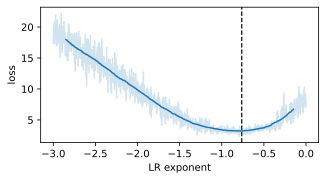

In [13]:
model = MLP(embedding_size=2, width=100, block_size=3)

plt.figure(figsize=(5, 2.5))
lr0 = find_base_lr(model, xs, ys, num_steps=1000, lre_min=-3, lre_max=0)
plt.axvline(math.log10(lr0), linestyle='dashed', linewidth=1.2, color='black', zorder=-1)
print(lr0)

### Increasing network width

To tune the other parameters, we first need to setup a validation set. Otherwise, we can just overfit on the training set. Note that we have a **schedule** for decreasing the learning rate as training progresses.

In [14]:
from sklearn.model_selection import StratifiedKFold

def create_folds(xs, ys, seed=42):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    folds = torch.zeros(xs.shape[0])
    for fold, (trn_, val_) in enumerate(kf.split(xs, ys)):
        folds[val_] = fold

    xs_trn, ys_trn = xs[folds >  1], ys[folds >  1]
    xs_dev, ys_dev = xs[folds == 1], ys[folds == 1]
    xs_tst, ys_tst = xs[folds == 0], ys[folds == 0]

    return xs_trn, ys_trn, xs_dev, ys_dev, xs_tst, ys_tst


def cross_entropy_loss(model, xs, ys):
    return F.cross_entropy(model(xs), ys)


def train_model(
        model,
        xs_trn, ys_trn,
        xs_dev, ys_dev,
        batch_size,
        num_steps,
        lr=0.1,
        verbose=True, seed=42
    ):

    losses_trn = {}
    losses_dev = {}

    g = torch.Generator().manual_seed(seed)
    lr_counter = 0
    best_loss_dev = float("inf")
    print(f"Setting learning rate to {lr:.2e}")

    for k in range(num_steps):
        loss = train_step(model, xs_trn, ys_trn, g, batch_size, lr)
        losses_trn[k] = loss
        
        if k > 0 and ((k % (num_steps // batch_size) == 0) or (k == num_steps - 1)):
            with torch.no_grad():
                loss_dev = F.cross_entropy(model(xs_dev), ys_dev)
                losses_dev[k] = loss_dev.item()
            
            if verbose:
                print(f"[{k+1:>0{int(len(str(num_steps)))}d}/{num_steps}]    loss={loss:.4f}    dev_loss={loss_dev:.4f}")
    
            if loss_dev.item() < best_loss_dev:
                best_loss_dev = loss_dev.item()
                lr_counter = 0
            else:
                lr_counter += 1
                if lr_counter == 3:
                    lr *= 0.1
                    lr_counter = 0
                    if verbose:
                        print(f"Decreasing learning rate to {lr:.2e}")
                    
    return {"loss_trn": losses_trn, "loss_dev": losses_dev}

Splitting and finding hidden layer width:

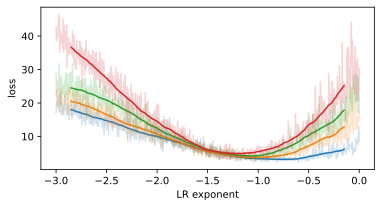

In [15]:
xs_trn, ys_trn, \
xs_dev, ys_dev, \
xs_tst, ys_tst = create_folds(xs, ys)

best_lr0 = []
plt.figure(figsize=(6, 3))
for i, h in enumerate(range(100, 500, 100)):
    model = MLP(embedding_size=2, width=h, block_size=3)
    lr0 = find_base_lr(model, xs_trn, ys_trn, num_steps=1000, color=f"C{i}")
    best_lr0.append(lr0);

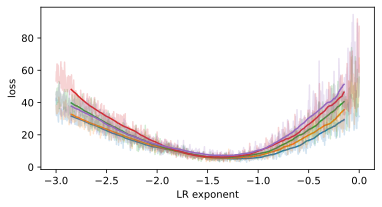

In [16]:
plt.figure(figsize=(6, 3))
for i, h in enumerate(range(500, 1000, 100)):
    model = MLP(embedding_size=2, width=h, block_size=3)
    lr0 = find_base_lr(model, xs_trn, ys_trn, num_steps=1000, color=f"C{i}")
    best_lr0.append(lr0)

Looks like we have a good range. Training with different network widths:

In [17]:
from tqdm import tqdm_notebook as tqdm

results = {}
for i, h in tqdm(enumerate(range(100, 1000, 100))):
    lr0 = best_lr0[i]
    model = MLP(embedding_size=2, width=h, block_size=3)
    hist = train_model(model, xs_trn, ys_trn, xs_dev, ys_dev, batch_size=32, num_steps=200000, lr=lr0, verbose=False)
    results[h] = hist

0it [00:00, ?it/s]

Setting learning rate to 1.82e-01
Setting learning rate to 8.95e-02
Setting learning rate to 8.47e-02
Setting learning rate to 6.12e-02
Setting learning rate to 6.12e-02
Setting learning rate to 4.91e-02
Setting learning rate to 4.27e-02
Setting learning rate to 4.21e-02
Setting learning rate to 4.97e-02


Plotting training history:

0it [00:00, ?it/s]

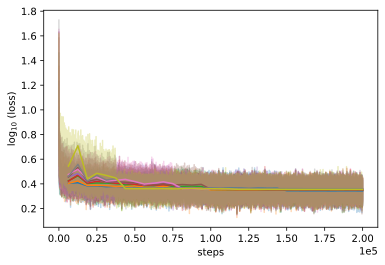

In [18]:
for i, h in tqdm(enumerate(range(100, 1000, 100))):    
    hist = results[h]
    plt.plot(hist['loss_trn'].keys(), torch.tensor(list(hist['loss_trn'].values())).log10(), color=f"C{i}", alpha=0.3);
    plt.plot(hist['loss_dev'].keys(), torch.tensor(list(hist['loss_dev'].values())).log10(), color=f"C{i}", zorder=3);

plt.xlabel("steps")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel("$\log_{10}$ (loss)");

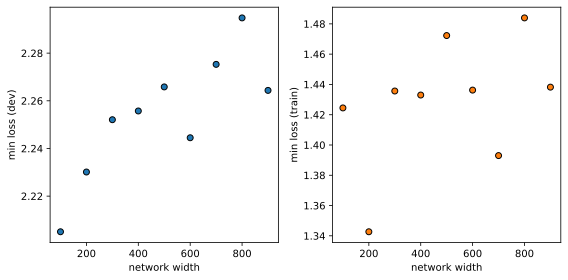

In [19]:
train_results = lambda h: min(results[h]['loss_trn'].values())
valid_results = lambda h: min(results[h]['loss_dev'].values())

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(results.keys(),[valid_results(h) for h in results.keys()], edgecolor='black', color='C0')
ax[1].scatter(results.keys(),[train_results(h) for h in results.keys()], edgecolor='black', color='C1')
ax[0].set_xlabel('network width')
ax[0].set_ylabel('min loss (dev)');
ax[1].set_xlabel('network width')
ax[1].set_ylabel('min loss (train)');
fig.tight_layout()

It looks like increasing only the network width results in worse validation loss. And that the network fails to overfit on the training dataset. This indicates that either there is not enough data to train the model, or that embedding size acts like a **bottleneck** to network capacity. We investigate this in the next sections. 

### Visualizing trained character embeddings

In this section we will look at embeddings of chacters in two-dimensional space. This will not be possible if we increase the dimensions of the embedding space. Although, there are techniques for visualizing high-dimensional space such as [t-SNE](https://lvdmaaten.github.io/tsne/). Recall from the network structure that, vectors with similar embeddings have similar roles in predicting the next character. 

In [20]:
model = MLP(embedding_size=2, width=100, block_size=3)
hist = train_model(
    model, 
    xs_trn, ys_trn, 
    xs_dev, ys_dev, 
    batch_size=32, 
    num_steps=200000, 
    lr=find_base_lr(model, xs_trn, ys_trn, num_steps=1000, plot=False), 
    verbose=True
)

Setting learning rate to 1.82e-01
[006251/200000]    loss=2.6363    dev_loss=2.4998
[012501/200000]    loss=2.6002    dev_loss=2.5710
[018751/200000]    loss=2.3607    dev_loss=2.4490
[025001/200000]    loss=2.4719    dev_loss=2.4118
[031251/200000]    loss=3.0837    dev_loss=2.3975
[037501/200000]    loss=2.4464    dev_loss=2.4080
[043751/200000]    loss=2.7772    dev_loss=2.4009
[050001/200000]    loss=2.1942    dev_loss=2.3713
[056251/200000]    loss=2.5362    dev_loss=2.3549
[062501/200000]    loss=2.0379    dev_loss=2.3534
[068751/200000]    loss=2.1108    dev_loss=2.3933
[075001/200000]    loss=2.7647    dev_loss=2.3373
[081251/200000]    loss=2.6705    dev_loss=2.3241
[087501/200000]    loss=2.0304    dev_loss=2.3388
[093751/200000]    loss=2.3752    dev_loss=2.3660
[100001/200000]    loss=2.1744    dev_loss=2.3253
Decreasing learning rate to 1.82e-02
[106251/200000]    loss=2.2210    dev_loss=2.2329
[112501/200000]    loss=2.0980    dev_loss=2.2326
[118751/200000]    loss=2.613

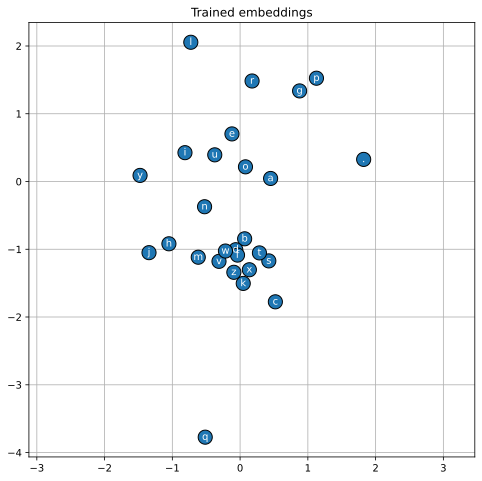

In [21]:
plt.figure(figsize=(8, 8))
plt.scatter(model.C[:, 0].data, model.C[:, 1].data, s=200, edgecolors='black', zorder=3)
for i in range(model.C.shape[0]):
    plt.text(model.C[i, 0].item(), model.C[i, 1].item(), itos[i], ha="center", va="center", color='white')

plt.grid('minor')
plt.axis('equal')
plt.title("Trained embeddings");

Observe that the vowels are clustered together. And there are vectors such as `q` and `.` that are far away from other vectors. We can say that the network has learned these characters. On the other hand, the other consonants being clustered too tightly indicates that the network is not able to understand the subtle differences with these characters, hence just grouping them together.

It seems like it will be difficult improve this with further training or improvements to the network hyparameters. Indeed, we saw that increasing network width, which should have resulted in overfitting the training set, resulted in increasing train and validation losses. In the next section, we will increase the number of dimensions of the embedding space and see whether this improves performance.

### Increasing the embedding dimension

Finding a good base learning rate:

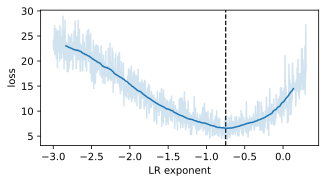

In [22]:
model = MLP(width=180, embedding_size=8, block_size=3)

plt.figure(figsize=(5, 2.5))
lr0 = find_base_lr(model, xs_trn, ys_trn, lre_min=-3, lre_max=0.3, num_steps=1200)
plt.axvline(math.log10(lr0), linestyle='dashed', linewidth=1.2, color='black', zorder=-1);

Model training:

Setting learning rate to 1.78e-01
[009376/300000]    loss=2.3518    dev_loss=2.5301
[018751/300000]    loss=2.5406    dev_loss=2.4366
[028126/300000]    loss=2.1505    dev_loss=2.4333
[037501/300000]    loss=2.4124    dev_loss=2.4934
[046876/300000]    loss=2.5794    dev_loss=2.3742
[056251/300000]    loss=2.6626    dev_loss=2.4033
[065626/300000]    loss=2.3633    dev_loss=2.4187
[075001/300000]    loss=3.1224    dev_loss=2.3703
[084376/300000]    loss=2.4759    dev_loss=2.4317
[093751/300000]    loss=2.4841    dev_loss=2.5388
[103126/300000]    loss=2.0409    dev_loss=2.4496
Decreasing learning rate to 1.78e-02
[112501/300000]    loss=1.7568    dev_loss=2.1720
[121876/300000]    loss=2.2355    dev_loss=2.1655
[131251/300000]    loss=1.4958    dev_loss=2.1685
[140626/300000]    loss=1.6672    dev_loss=2.1645
[150001/300000]    loss=1.9311    dev_loss=2.1725
[159376/300000]    loss=1.6104    dev_loss=2.1699
[168751/300000]    loss=2.0342    dev_loss=2.1638
[178126/300000]    loss=2.327

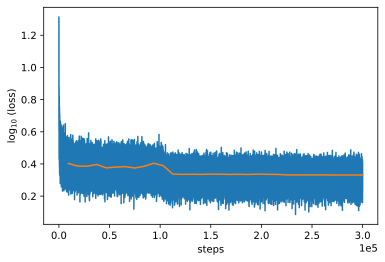

In [23]:
hist = train_model(
    model,
    xs_trn, ys_trn, 
    xs_dev, ys_dev, 
    batch_size=32, 
    num_steps=300000, 
    lr=lr0
)

plt.plot(hist['loss_trn'].keys(), torch.tensor(list(hist['loss_trn'].values())).log10())
plt.plot(hist['loss_dev'].keys(), torch.tensor(list(hist['loss_dev'].values())).log10())

plt.xlabel("steps")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel("$\log_{10}$ (loss)");

## Sampling names

Finally, we look at names generated by the model.

In [24]:
def generate_names(model, block_size, sample_size, seed=2147483647):
    """Generate names from a Markov process with cond probability table P."""

    g = torch.Generator().manual_seed(seed)
    names = []
    for _ in range(sample_size):
        out = []
        context = [0] * block_size
        while True:
            p = model(torch.tensor(context)).exp()
            j = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            if j == 0:
                break
            context = context[1:] + [j]
            out.append(itos[j])
        names.append(''.join(out))
    return names


def name_loss(name, model, block_size):
    nll = 0.0
    context = [0] * block_size
    for c in name + '.':
        p = F.softmax(model(torch.tensor(context))).reshape(-1)[stoi[c]]
        nll += -math.log(p)
        context = context[1:] + [stoi[c]]
    return nll / (len(name) + 1)


sample = generate_names(model, block_size=3, sample_size=12, seed=13)
name_losses = {n: name_loss(n, model, block_size=3) for n in sample}
for n in sorted(sample, key=lambda n: name_losses[n]):
    print(f"{n:<22} {name_losses[n]:.3f}")


neeson                 1.801
malara                 1.814
sael                   1.857
avara                  1.908
ashmelan               1.909
ane                    1.938
levonti                2.011
easter                 2.013
tisyn                  2.314
jur                    2.397
sierollo               2.580
zyokn                  3.034


Nice! This is a huge improvement from the previous notebook.